# Relax Take Home Challenge

### Silas Lee

### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt


users = pd.read_csv('takehome_users.csv', encoding = 'Latin-1', parse_dates=True)
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [10]:
display(users.describe())
display(engagement.head())

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000,12000.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145,0.138000
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968,0.344914
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,0.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000,0.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000,0.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000,0.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [4]:
#set the time_stamp to datetime and the set it as the index
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement = engagement.set_index('time_stamp', drop= True)

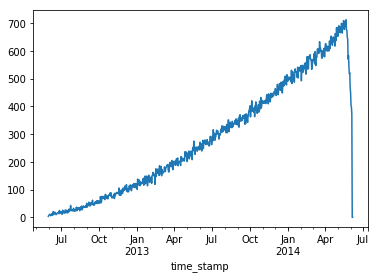

In [16]:
engagement['visited'].resample('1D').sum().plot()

In [17]:
def label_adopted(x):    
    df_temp = engagement.loc[engagement['user_id'] == x] 
    df_temp = df_temp.resample('D').mean()
    df_temp = df_temp.dropna() 
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [18]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [19]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [20]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.object_id))

1656
0.138


### Out of 12000 users, only 1656 can be considered an adopted user, roughly 14%. 

In [21]:
processed = users.copy()
processed = pd.get_dummies(processed, columns = ['invited_by_user_id'], dummy_na= True) #Just want to know if invited or not
processed = processed[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id_nan', 'adopted_user']]
processed.rename(columns={'invited_by_user_id_nan': 'Not_invited'}, inplace=True)
processed = pd.get_dummies(processed, columns = ['creation_source']) # convert categorical data
display(processed.head())

,opted_in_to_mailing_list,enabled_for_marketing_drip,Not_invited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,0,0,1,0,0,0,0
1,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


### Build Random Forest Classifier and test for feature importance

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

y = processed['adopted_user']
X = processed.drop('adopted_user', axis = 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

Feature ranking:
1. feature 5 (0.501550)
2. feature 3 (0.139051)
3. feature 7 (0.129609)
4. feature 4 (0.067701)
5. feature 2 (0.053264)
6. feature 6 (0.046199)
7. feature 1 (0.035006)
8. feature 0 (0.027619)


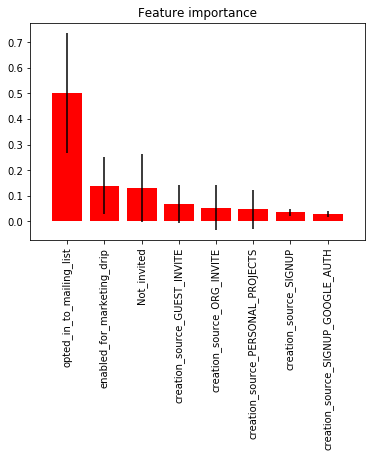

In [23]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    
feature_names = X.columns
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()


### Use xgboost to test for feature importance

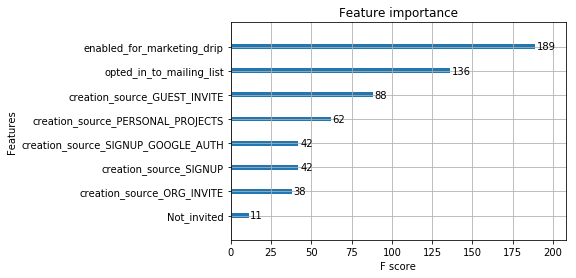

In [24]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

In [25]:
display(users.groupby('adopted_user').mean())

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
adopted_user,,,,,,
0,5993.165603,1.375596e+09,0.247970,0.148395,138.559261,5961.292839
1,6046.313406,1.395221e+09,0.259058,0.155193,162.655797,5972.618240


In [26]:
print(users['enabled_for_marketing_drip'].sum()/len(users['object_id']))

0.14933333333333335


In [27]:
active = users[users['adopted_user']==1]
notactive = users[users['adopted_user']==0]

active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 1 to 11987
Data columns (total 11 columns):
object_id                     1656 non-null int64
creation_time                 1656 non-null object
name                          1656 non-null object
email                         1656 non-null object
creation_source               1656 non-null object
last_session_creation_time    1656 non-null float64
opted_in_to_mailing_list      1656 non-null int64
enabled_for_marketing_drip    1656 non-null int64
org_id                        1656 non-null int64
invited_by_user_id            943 non-null float64
adopted_user                  1656 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 155.2+ KB


In [28]:
print('Percent of Adopted Users enabled for marketing drip: ' , active['enabled_for_marketing_drip'].sum()/len(active['object_id']))
print('Percent of not Adopted Users enabled for marketing drip: ' , notactive['enabled_for_marketing_drip'].sum()/len(notactive['object_id']))

Percent of Adopted Users enabled for marketing drip:  0.15519323671497584
Percent of not Adopted Users enabled for marketing drip:  0.1483952049497293


In [29]:
print('Percent of Adopted Users opted into mailing list: ' , active['opted_in_to_mailing_list'].sum()/len(active['object_id']))
print('Percent of not Adopted Users opted into mailing list: ' ,notactive['opted_in_to_mailing_list'].sum()/len(notactive['object_id']))

Percent of Adopted Users opted into mailing list:  0.25905797101449274
Percent of not Adopted Users opted into mailing list:  0.24796983758700697


Using two different methods to extract feature importance, both suggest that users enabled for marketing drip and users who opted into the mailing list were more likely to be adopted users. I would suggest trying to raise the numbers of users in each. Also being guest invited is correlated to being an adopted user.